In [1]:
import pandas as pd

df = pd.read_csv("dataset-modified.csv", index_col=0)
train_df = pd.read_csv("train.csv", index_col=0)
test_df = pd.read_csv("test.csv", index_col=0)

# full dataset
X = df.drop("Class", axis=1)
y = df["Class"]

# splits
X_train = train_df.drop("Class", axis=1)
y_train = train_df["Class"]
X_test = test_df.drop("Class", axis=1)
y_test = test_df["Class"]

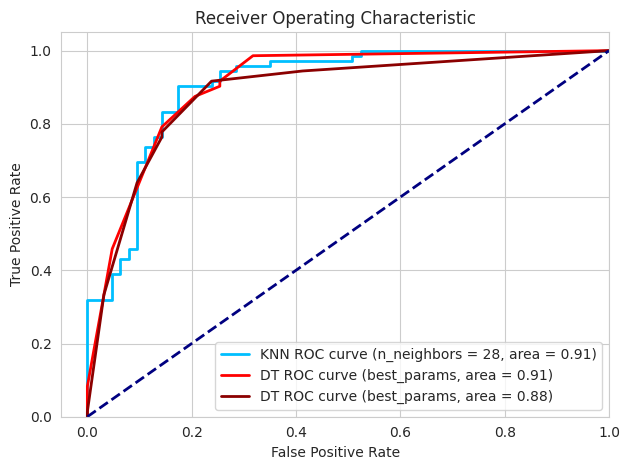

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure()

knn = KNeighborsClassifier(n_neighbors=28, weights="distance").fit(X_train, y_train)

y_scores = knn.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label="Kecimen")
roc_auc = auc(fpr, tpr)

plt.plot(
    fpr,
    tpr,
    color="deepskyblue",
    lw=2,
    label=f"KNN ROC curve (n_neighbors = 28, area = {roc_auc:.2f})",
)

dt = DecisionTreeClassifier(
    max_depth=3,
    random_state=12,
    max_features="sqrt",
    splitter="best",
    criterion="entropy",
).fit(X_train, y_train)

y_scores = dt.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label="Kecimen")
roc_auc = auc(fpr, tpr)
plt.plot(
    fpr,
    tpr,
    color="red",
    lw=2,
    label=f"DT ROC curve (best_params, area = {roc_auc:.2f})",
)

dt = DecisionTreeClassifier(
    max_depth=3,
    random_state=12,
    max_features=0.8,
    splitter="random",
    criterion="gini",
).fit(X_train, y_train)

y_scores = dt.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label="Kecimen")
roc_auc = auc(fpr, tpr)
plt.plot(
    fpr,
    tpr,
    color="darkred",
    lw=2,
    label=f"DT ROC curve (best_params, area = {roc_auc:.2f})",
)

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score


def get_result_stats(clf, X, y, pos_label="Kecimen"):
    y_pred = clf.predict(X)
    y_prob = clf.predict_proba(X)[:, 1]

    conf_matrix = confusion_matrix(y, y_pred, labels=["Kecimen", "Besni"])
    acc = accuracy_score(y, y_pred)
    auc_score = roc_auc_score(y, y_prob)
    precision = precision_score(y, y_pred, pos_label=pos_label)
    recall = recall_score(y, y_pred, pos_label=pos_label)
    f1 = f1_score(y, y_pred, pos_label=pos_label)

    return y_pred, acc, auc_score, precision, recall, f1, conf_matrix


results = []

clf = DecisionTreeClassifier(
    max_depth=3,
    random_state=12,
    max_features="sqrt",
    splitter="best",
    criterion="entropy",
)
clf.fit(X_train, y_train)
_, acc, auc_score, precision, recall, f1, _ = get_result_stats(clf, X_test, y_test)
results.append(["Holdout", acc, auc_score, precision, recall, f1])

clf = DecisionTreeClassifier(
    max_depth=3,
    random_state=12,
    max_features="sqrt",
    splitter="best",
    criterion="entropy",
)
cv_results = []
for metric in ['accuracy', 'roc_auc', 'precision_macro', 'recall_macro', 'f1_macro']:
    scores = cross_val_score(clf, X, y, scoring=metric, cv=10)
    cv_results.append(scores.mean())
results.append(["Cross-Validation"] + cv_results)

clf = DecisionTreeClassifier(
    max_depth=3,
    random_state=12,
    max_features="sqrt",
    splitter="best",
    criterion="entropy",
)
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=10, random_state=42)
bagging_clf.fit(X_train, y_train)
_, acc, auc_score, precision, recall, f1, _ = get_result_stats(bagging_clf, X_test, y_test)
results.append(["Bagging", acc, auc_score, precision, recall, f1])

columns = ["Strategy", "Accuracy", "AUC", "Precision", "Recall", "F1 Score"]
results_df = pd.DataFrame(results, columns=columns)
display(results_df)
results_df.to_latex(
    "./dt-strategy-scores-common.tex",
    float_format="%.3f",
    caption="Apskaičiuoti skirtingų strategijų matai",
    label="tab:dt-strategy-scores-common",
    index=False,
    escape=True,
    bold_rows=True,
)

,Strategy,Accuracy,AUC,Precision,Recall,F1 Score
0,Holdout,0.837037,0.905864,0.828947,0.875000,0.851351
1,Cross-Validation,0.852222,0.909630,0.857673,0.852222,0.851520
2,Bagging,0.829630,0.893188,0.855072,0.819444,0.836879


In [22]:
results = []

clf = KNeighborsClassifier(n_neighbors=28, weights="distance")
clf.fit(X_train, y_train)
_, acc, auc_score, precision, recall, f1, _ = get_result_stats(clf, X_test, y_test)
results.append(["Holdout", acc, auc_score, precision, recall, f1])

clf = KNeighborsClassifier(n_neighbors=28, weights="distance")
cv_results = []
for metric in ['accuracy', 'roc_auc', 'precision_macro', 'recall_macro', 'f1_macro']:
    scores = cross_val_score(clf, X, y, scoring=metric, cv=10)
    cv_results.append(scores.mean())
results.append(["Cross-Validation"] + cv_results)

clf = KNeighborsClassifier(n_neighbors=28, weights="distance").fit(X_train, y_train)
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=10, random_state=42)
bagging_clf.fit(X_train, y_train)
_, acc, auc_score, precision, recall, f1, _ = get_result_stats(bagging_clf, X_test, y_test)
results.append(["Bagging", acc, auc_score, precision, recall, f1])

columns = ["Strategy", "Accuracy", "AUC", "Precision", "Recall", "F1 Score"]
results_df = pd.DataFrame(results, columns=columns)
display(results_df)
results_df.to_latex(
    "./knn-strategy-scores-common.tex",
    float_format="%.3f",
    caption="Apskaičiuoti skirtingų strategijų matai",
    label="tab:knn-strategy-scores-common",
    index=False,
    escape=True,
    bold_rows=True,
)

,Strategy,Accuracy,AUC,Precision,Recall,F1 Score
0,Holdout,0.837037,0.905644,0.867647,0.819444,0.842857
1,Cross-Validation,0.853333,0.913210,0.857746,0.853333,0.852723
2,Bagging,0.837037,0.902998,0.857143,0.833333,0.845070
